In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from Bayesian2 import BayesianLinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dtype_dict = {
    'Date': 'str',
    'FarmName_Pseudo': 'str',
    'SE_Number': 'str',
    'Age': 'Int64',
    'BreedName': 'str',
    'DailyYield': 'float',
    'PreviousDailyYield': 'float',
    'DailyYieldChange': 'float',
    'DaysInMilk': 'float',
    'YearSeason': 'str',
    'LactationNumber': 'float',
    'ExpectedYield': 'float',
    'NormalizedDailyYield': 'float',
    'NormalizedDailyYieldChange': 'float',
    'HeatStress': 'Int64',
    'Temp15Threshold': 'Int64',
    'HW': 'Int64',
    'cum_HW': 'Int64',
    'MeanTemperature': 'float',
    'MeanTHI_adj': 'float',
    'FarmHeatStressMilkProduction': 'float'
}

milk_data = pd.read_csv('../Data/MergedData/BLRMilkFarmYieldData.csv', dtype=dtype_dict)
milk_data['Date'] = pd.to_datetime(milk_data['Date'], format='%Y-%m-%d')
# Update YearSeason to 'YYYY-S' format
milk_data['YearSeason'] = milk_data['Date'].dt.year.astype(str) + '-' + milk_data['Date'].dt.month.sub(1).floordiv(3).add(1).astype(str)

# Calculate the LactationStartDate
milk_data['LactationStartDate'] = milk_data.groupby(['SE_Number', 'LactationNumber'])['Date'].transform('min')

# Get the Age at the LactationStartDate
lactation_start_age = milk_data[milk_data['Date'] == milk_data['LactationStartDate']].set_index(['SE_Number', 'LactationNumber'])['Age']

# Merge the start age back into the original DataFrame
milk_data = milk_data.merge(lactation_start_age.rename('AgeAtLactationStart'), on=['SE_Number', 'LactationNumber'])

# Encode categorical data
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_breeds = pd.DataFrame(encoder.fit_transform(milk_data[['BreedName']]), columns=encoder.get_feature_names_out(['BreedName']))
milk_data = pd.concat([milk_data, encoded_breeds], axis=1)
milk_data.head(-5)

,Date,FarmName_Pseudo,SE_Number,Age,BreedName,LactationNumber,DaysInMilk,YearSeason,DailyYield,PreviousDailyYield,...,FarmHeatStressMilkProduction,LactationStartDate,AgeAtLactationStart,BreedName_02 SLB,BreedName_04 SJB,BreedName_06 RB,BreedName_27 Montbéliard,BreedName_41 Fjällko,BreedName_99 Korsning/obestämbar ras,BreedName_Unknown Breed
0,2022-01-01,a624fb9a,SE-064c0cec-1189,3095,02 SLB,7.0,191.0,2022-1,30.77,0.000000,...,NaN,2022-01-01,3095,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-01-02,a624fb9a,SE-064c0cec-1189,3096,02 SLB,7.0,192.0,2022-1,48.22,30.770000,...,NaN,2022-01-01,3095,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-01-03,a624fb9a,SE-064c0cec-1189,3097,02 SLB,7.0,193.0,2022-1,30.53,39.495000,...,NaN,2022-01-01,3095,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-01-04,a624fb9a,SE-064c0cec-1189,3098,02 SLB,7.0,194.0,2022-1,42.26,36.506667,...,NaN,2022-01-01,3095,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-01-05,a624fb9a,SE-064c0cec-1189,3099,02 SLB,7.0,195.0,2022-1,38.49,37.945000,...,NaN,2022-01-01,3095,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483097,2023-06-03,f454e660,SE-fcdf259d-0044-0,4150,41 Fjällko,10.0,347.0,2023-2,12.67,14.652000,...,NaN,2022-06-25,3807,0.0,0.0,0.0,0.0,1.0,0.0,0.0
483098,2023-06-04,f454e660,SE-fcdf259d-0044-0,4151,41 Fjällko,10.0,348.0,2023-2,22.31,14.030000,...,NaN,2022-06-25,3807,0.0,0.0,0.0,0.0,1.0,0.0,0.0
483099,2023-06-05,f454e660,SE-fcdf259d-0044-0,4152,41 Fjällko,10.0,349.0,2023-2,12.84,14.984000,...,NaN,2022-06-25,3807,0.0,0.0,0.0,0.0,1.0,0.0,0.0
483100,2023-06-06,f454e660,SE-fcdf259d-0044-0,4153,41 Fjällko,10.0,350.0,2023-2,9.47,14.892000,...,NaN,2022-06-25,3807,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Farm a624fb9a

In [3]:
# Select the farm
farm = 'a624fb9a'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Ensure the feature 'MeanTemperature' is float type
daily_farm_data['MeanTemperature'] = daily_farm_data['MeanTemperature'].astype(float)

# Scale features
scaler = StandardScaler()
daily_farm_data[['MeanTemperature', 'Age']] = scaler.fit_transform(daily_farm_data[['MeanTemperature', 'Age']])

# Function to fit model and calculate yield change
def fit_model_and_calculate_yield_change(data, feature, additional_features):
    yield_changes = []
    grouped_data = data.groupby(['YearSeason', 'SE_Number'])
    
    for (year_season, cow), group in grouped_data:
        cow_data = group

        # Prepare features
        X = cow_data[[feature] + additional_features]
        y = cow_data['NormalizedDailyYield']

        # Calculate prior mean and variance
        cow_mean = y.mean()
        cow_variance = y.var() if y.var() > 1e-6 else 1e-6
        beta = 1 / cow_variance
        prior_mean_value = X.mean(axis=0)

        # Define priors
        prior_mean = np.append([cow_mean], prior_mean_value.values).reshape(-1, 1)
        prior_cov = np.eye(len(prior_mean)) * 0.01

        # Fit model
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=[feature] + additional_features,
            target='NormalizedDailyYield',
            subject_type='cow',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()

        # Store results
        yield_changes.append({
            'YearSeason': year_season,
            'SE_Number': cow,
            'Yield HeatStress': result['Off-set']['mu']
        })

    return pd.DataFrame(yield_changes)

# Define features
selected_feature = 'MeanTemperature'
additional_features = list(encoded_breeds.columns) + ['Age']

# Separate data for HeatStress=1 and HeatStress=0 conditions
data_heatstress_1 = daily_farm_data[daily_farm_data['HeatStress'] == 1]
data_heatstress_0 = daily_farm_data[daily_farm_data['HeatStress'] == 0]

# Fit models and calculate yield changes
yield_changes_heatstress_1 = fit_model_and_calculate_yield_change(data_heatstress_1, selected_feature, additional_features)
yield_changes_heatstress_0 = fit_model_and_calculate_yield_change(data_heatstress_0, selected_feature, additional_features)

# Merge results with breed data and calculate deviations
results_df = yield_changes_heatstress_1.merge(
    yield_changes_heatstress_0, on=['YearSeason', 'SE_Number'], suffixes=('=1', '=0')
)

# Merge age and breed data back to results_df using the AgeAtLactationStart column
# Ensure unique combinations of SE_Number and YearSeason in the daily_farm_data for merging
unique_age_breed_data = daily_farm_data[['SE_Number', 'YearSeason', 'AgeAtLactationStart', 'BreedName']].drop_duplicates(subset=['SE_Number', 'YearSeason'])

results_df = results_df.merge(
    unique_age_breed_data, on=['SE_Number', 'YearSeason'], how='left'
)

# Calculate the correct deviation from baseline
# baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress_1['FarmHeatStressMilkProduction'].mean()
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change  # Corrected calculation

# Reorder columns to make SE_Number the first column
results_df = results_df[['SE_Number', 'YearSeason', 'AgeAtLactationStart', 'BreedName', 'Yield HeatStress=1', 'Yield HeatStress=0', 'Deviation from Baseline HeatStress=1']]
results_df

,SE_Number,YearSeason,AgeAtLactationStart,BreedName,Yield HeatStress=1,Yield HeatStress=0,Deviation from Baseline HeatStress=1
0,SE-064c0cec-1189,2022-2,3242,02 SLB,0.998898,1.043096,-0.001316
1,SE-30dc5787-1389,2022-2,2531,01 SRB,1.002258,0.701138,0.002044
2,SE-30dc5787-1396,2022-2,2479,02 SLB,0.995034,1.066005,-0.005180
3,SE-30dc5787-1402,2022-2,2462,02 SLB,0.993669,1.119951,-0.006545
4,SE-a624fb9a-1039,2022-2,4126,02 SLB,1.001278,1.080983,0.001064
...,...,...,...,...,...,...,...
384,SE-a624fb9a-1491,2023-3,714,01 SRB,0.785094,1.445859,-0.215120
385,SE-a624fb9a-1493,2023-3,766,01 SRB,1.016800,1.271889,0.016586
386,SE-a624fb9a-1496,2023-3,743,02 SLB,0.933067,0.885535,-0.067147
387,SE-a624fb9a-1503,2023-3,736,01 SRB,0.953963,0.814730,-0.046252


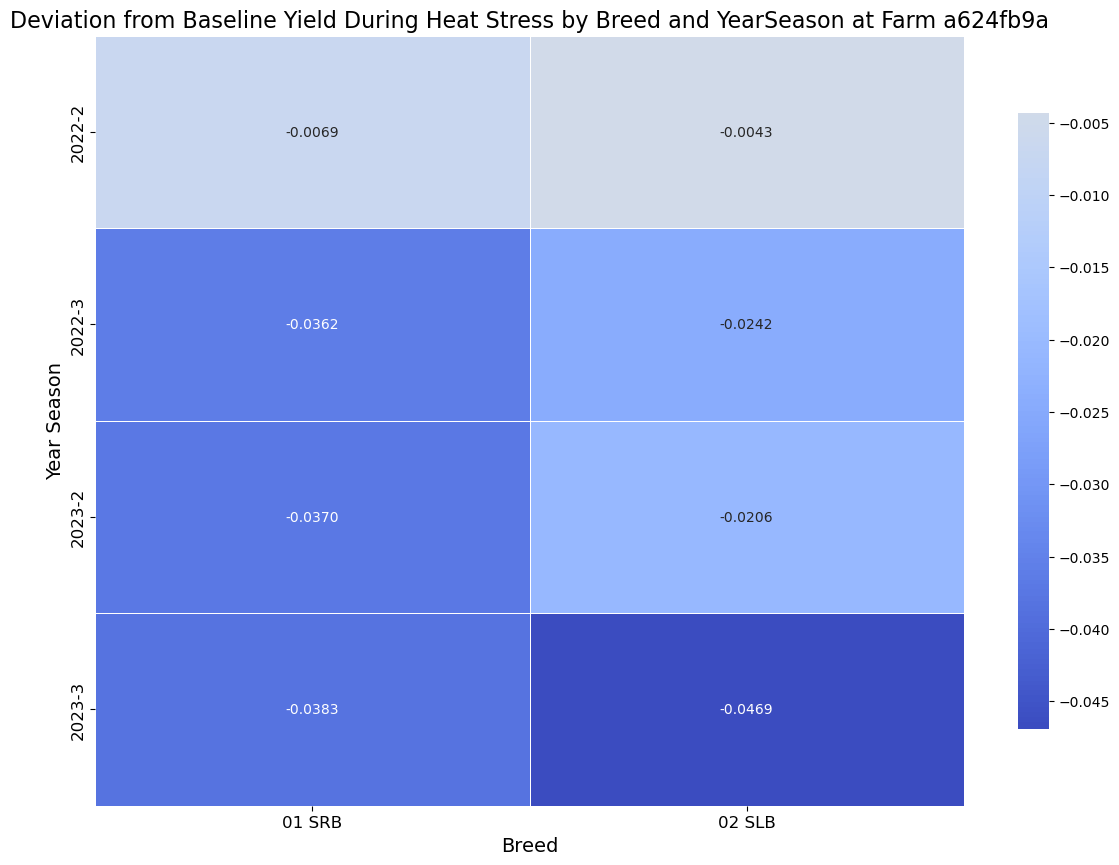

In [4]:
# Pivot data for heatmap
heatmap_data = results_df.pivot_table(index='YearSeason', columns='BreedName', values='Deviation from Baseline HeatStress=1')

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0, fmt=".4f", linewidths=.5, cbar_kws={"shrink": .8})
plt.title(f'Deviation from Baseline Yield During Heat Stress by Breed and YearSeason at Farm {farm}', fontsize=16)
plt.xlabel('Breed', fontsize=14)
plt.ylabel('Year Season', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

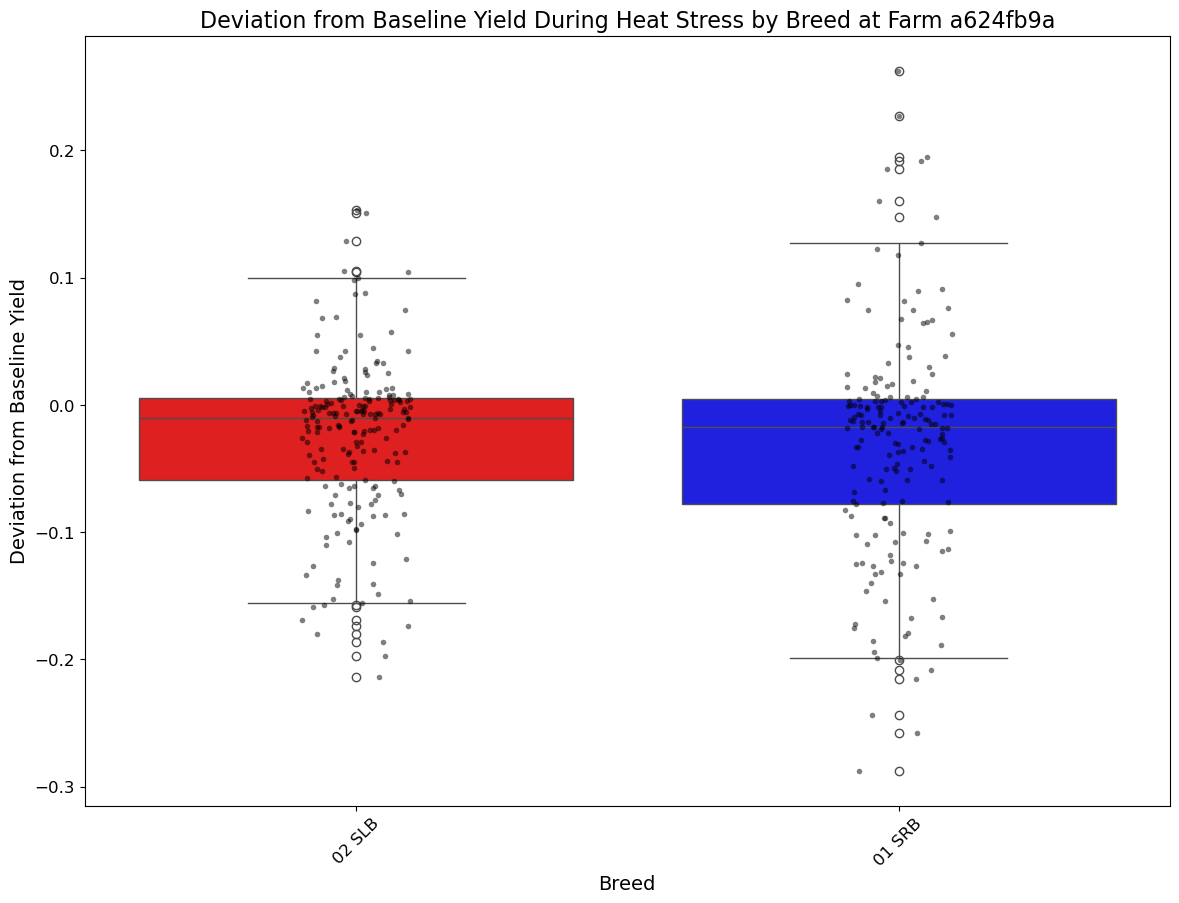

In [5]:
# Define a custom color palette with bright colors
custom_palette = ['#FF0000', '#0000FF']  # Bright red, Bright blue

plt.figure(figsize=(14, 10))
sns.boxplot(x='BreedName', y='Deviation from Baseline HeatStress=1', data=results_df, hue='BreedName', palette=custom_palette, dodge=False)
sns.stripplot(x='BreedName', y='Deviation from Baseline HeatStress=1', data=results_df, color='black', size=4, jitter=True, alpha=0.5, dodge=False)
plt.title(f'Deviation from Baseline Yield During Heat Stress by Breed at Farm {farm}', fontsize=16)
plt.xlabel('Breed', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend([],[], frameon=False)  # Remove the legend
plt.show()

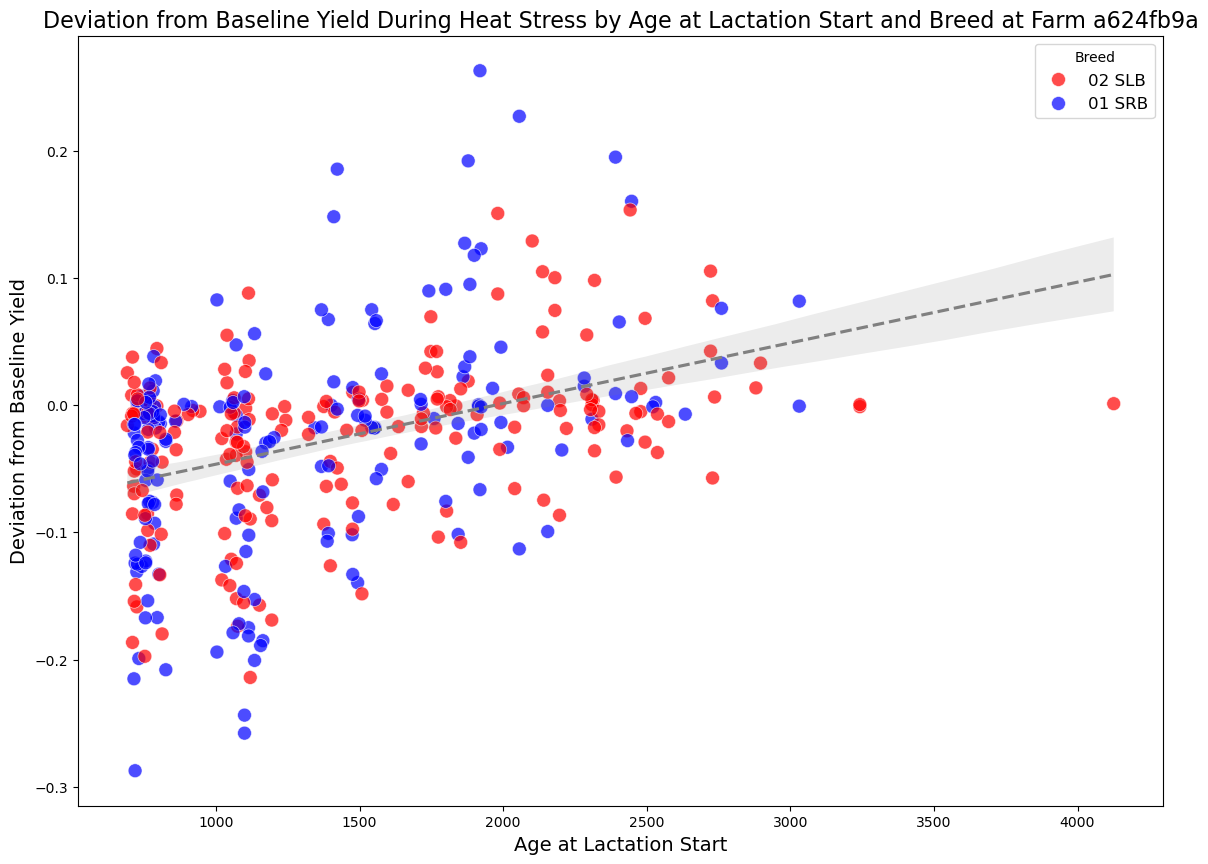

In [6]:
plt.figure(figsize=(14, 10))
sns.scatterplot(x='AgeAtLactationStart', y='Deviation from Baseline HeatStress=1', hue='BreedName', data=results_df, palette=custom_palette, s=100, alpha=0.7, edgecolor='w', linewidth=0.5)
sns.regplot(x='AgeAtLactationStart', y='Deviation from Baseline HeatStress=1', data=results_df, scatter=False, color='gray', line_kws={"linestyle":"--"})
plt.title(f'Deviation from Baseline Yield During Heat Stress by Age at Lactation Start and Breed at Farm {farm}', fontsize=16)
plt.xlabel('Age at Lactation Start', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.legend(title='Breed', fontsize=12)
plt.show()

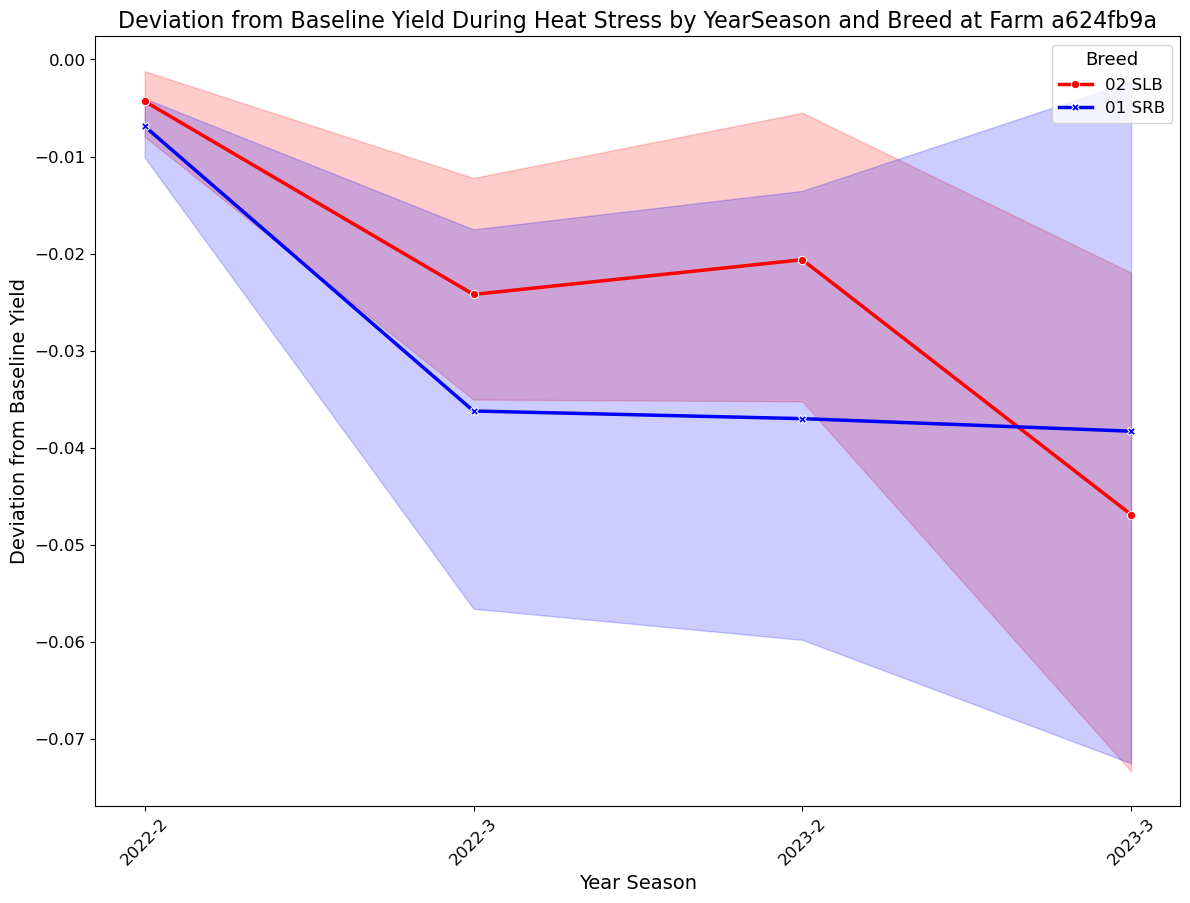

In [7]:
plt.figure(figsize=(14, 10))
sns.lineplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', hue='BreedName', data=results_df, marker='o', palette=custom_palette, linewidth=2.5, style='BreedName', markers=True, dashes=False)
plt.title(f'Deviation from Baseline Yield During Heat Stress by YearSeason and Breed at Farm {farm}', fontsize=16)
plt.xlabel('Year Season', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Breed', fontsize=12, title_fontsize='13')
plt.show()

## Farm 5c06d92d

In [8]:
# Select the farm
farm = '5c06d92d'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Ensure the feature 'MeanTemperature' is float type
daily_farm_data['MeanTemperature'] = daily_farm_data['MeanTemperature'].astype(float)

# Scale features
scaler = StandardScaler()
daily_farm_data[['MeanTemperature', 'Age']] = scaler.fit_transform(daily_farm_data[['MeanTemperature', 'Age']])

# Function to fit model and calculate yield change
def fit_model_and_calculate_yield_change(data, feature, additional_features):
    yield_changes = []
    grouped_data = data.groupby(['YearSeason', 'SE_Number'])
    
    for (year_season, cow), group in grouped_data:
        cow_data = group

        # Prepare features
        X = cow_data[[feature] + additional_features]
        y = cow_data['NormalizedDailyYield']

        # Calculate prior mean and variance
        cow_mean = y.mean()
        cow_variance = y.var() if y.var() > 1e-6 else 1e-6
        beta = 1 / cow_variance
        prior_mean_value = X.mean(axis=0)

        # Define priors
        prior_mean = np.append([cow_mean], prior_mean_value.values).reshape(-1, 1)
        prior_cov = np.eye(len(prior_mean)) * 0.01

        # Fit model
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=[feature] + additional_features,
            target='NormalizedDailyYield',
            subject_type='cow',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()

        # Store results
        yield_changes.append({
            'YearSeason': year_season,
            'SE_Number': cow,
            'Yield HeatStress': result['Off-set']['mu']
        })

    return pd.DataFrame(yield_changes)

# Define features
selected_feature = 'MeanTemperature'
additional_features = list(encoded_breeds.columns) + ['Age']

# Separate data for HeatStress=1 and HeatStress=0 conditions
data_heatstress_1 = daily_farm_data[daily_farm_data['HeatStress'] == 1]
data_heatstress_0 = daily_farm_data[daily_farm_data['HeatStress'] == 0]

# Fit models and calculate yield changes
yield_changes_heatstress_1 = fit_model_and_calculate_yield_change(data_heatstress_1, selected_feature, additional_features)
yield_changes_heatstress_0 = fit_model_and_calculate_yield_change(data_heatstress_0, selected_feature, additional_features)

# Merge results with breed data and calculate deviations
results_df = yield_changes_heatstress_1.merge(
    yield_changes_heatstress_0, on=['YearSeason', 'SE_Number'], suffixes=('=1', '=0')
)

# Merge age and breed data back to results_df using the AgeAtLactationStart column
# Ensure unique combinations of SE_Number and YearSeason in the daily_farm_data for merging
unique_age_breed_data = daily_farm_data[['SE_Number', 'YearSeason', 'AgeAtLactationStart', 'BreedName']].drop_duplicates(subset=['SE_Number', 'YearSeason'])

results_df = results_df.merge(
    unique_age_breed_data, on=['SE_Number', 'YearSeason'], how='left'
)

# Calculate the correct deviation from baseline
# baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress_1['FarmHeatStressMilkProduction'].mean()
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change  # Corrected calculation

# Reorder columns to make SE_Number the first column
results_df = results_df[['SE_Number', 'YearSeason', 'AgeAtLactationStart', 'BreedName', 'Yield HeatStress=1', 'Yield HeatStress=0', 'Deviation from Baseline HeatStress=1']]
results_df

,SE_Number,YearSeason,AgeAtLactationStart,BreedName,Yield HeatStress=1,Yield HeatStress=0,Deviation from Baseline HeatStress=1
0,SE-5c06d92d-2000,2022-2,3397,01 SRB,0.977477,0.938838,-0.022396
1,SE-5c06d92d-2016,2022-2,3373,02 SLB,1.013328,0.900975,0.013455
2,SE-5c06d92d-2055,2022-2,3285,02 SLB,0.992654,0.973511,-0.007219
3,SE-5c06d92d-2058,2022-2,3280,06 RB,0.970613,0.973300,-0.029260
4,SE-5c06d92d-2211,2022-2,2950,02 SLB,0.940930,0.841689,-0.058944
...,...,...,...,...,...,...,...
1009,SE-5c06d92d-3474,2023-3,704,02 SLB,0.904994,1.120073,-0.094879
1010,SE-5c06d92d-3475,2023-3,709,06 RB,0.936483,1.293068,-0.063391
1011,SE-5c06d92d-3478,2023-3,713,01 SRB,0.984961,1.068692,-0.014912
1012,SE-5c06d92d-3482,2023-3,708,01 SRB,1.079173,1.158369,0.079299


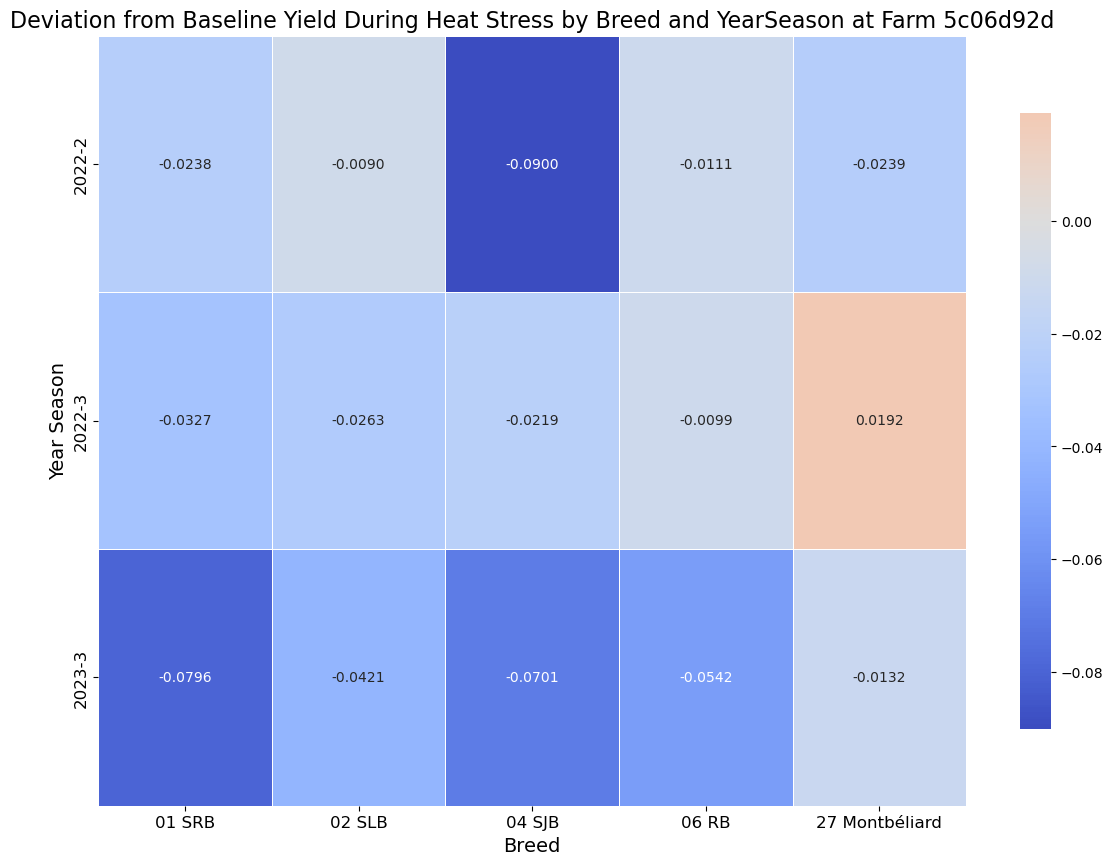

In [9]:
# Pivot data for heatmap
heatmap_data = results_df.pivot_table(index='YearSeason', columns='BreedName', values='Deviation from Baseline HeatStress=1')

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0, fmt=".4f", linewidths=.5, cbar_kws={"shrink": .8})
plt.title(f'Deviation from Baseline Yield During Heat Stress by Breed and YearSeason at Farm {farm}', fontsize=16)
plt.xlabel('Breed', fontsize=14)
plt.ylabel('Year Season', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

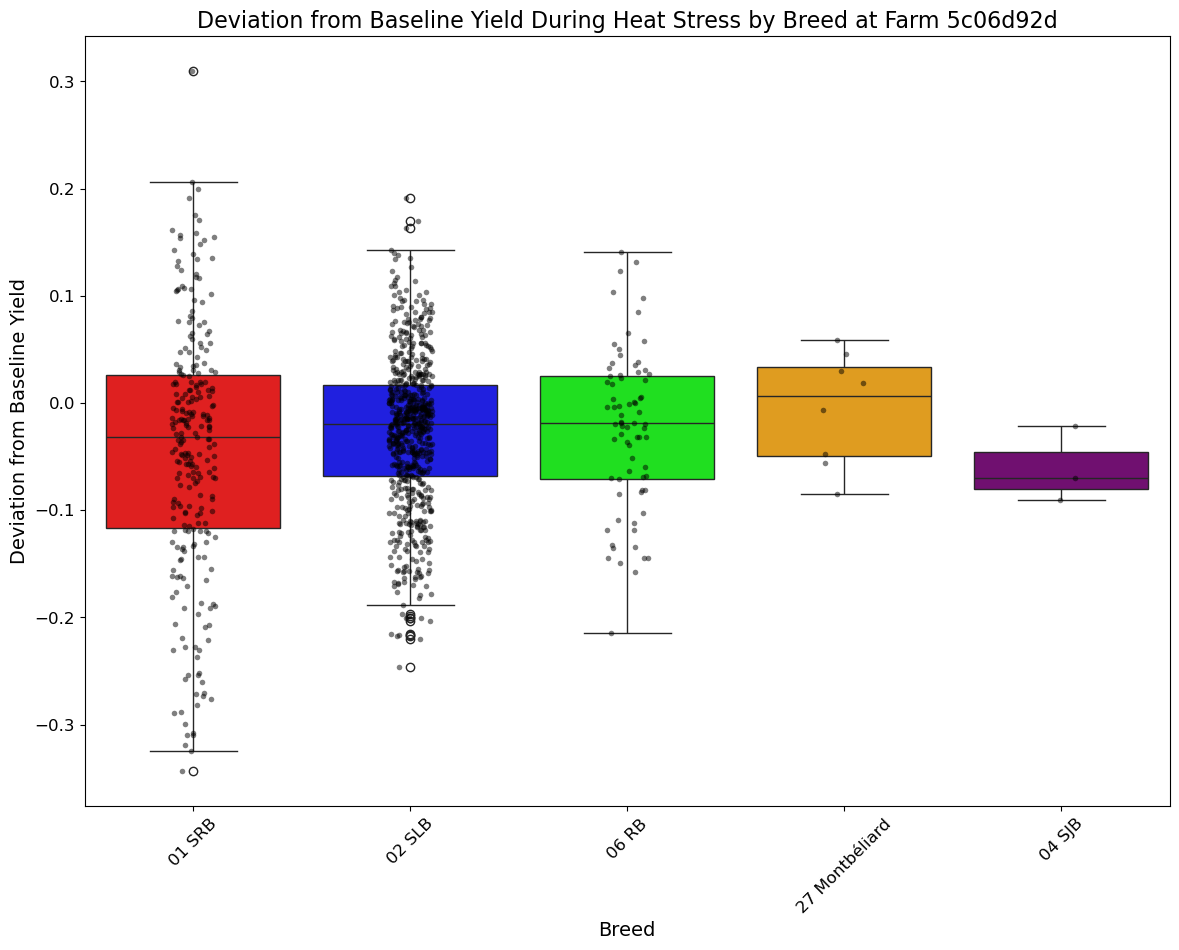

In [10]:
# Define a custom color palette with bright colors
custom_palette = ['#FF0000', '#0000FF', '#00FF00', '#FFA500', '#800080']  # Bright red, Bright blue, Bright green, Bright orange, Bright purple

plt.figure(figsize=(14, 10))
sns.boxplot(x='BreedName', y='Deviation from Baseline HeatStress=1', data=results_df, hue='BreedName', palette=custom_palette, dodge=False)
sns.stripplot(x='BreedName', y='Deviation from Baseline HeatStress=1', data=results_df, color='black', size=4, jitter=True, alpha=0.5, dodge=False)
plt.title(f'Deviation from Baseline Yield During Heat Stress by Breed at Farm {farm}', fontsize=16)
plt.xlabel('Breed', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend([],[], frameon=False)  # Remove the legend
plt.show()

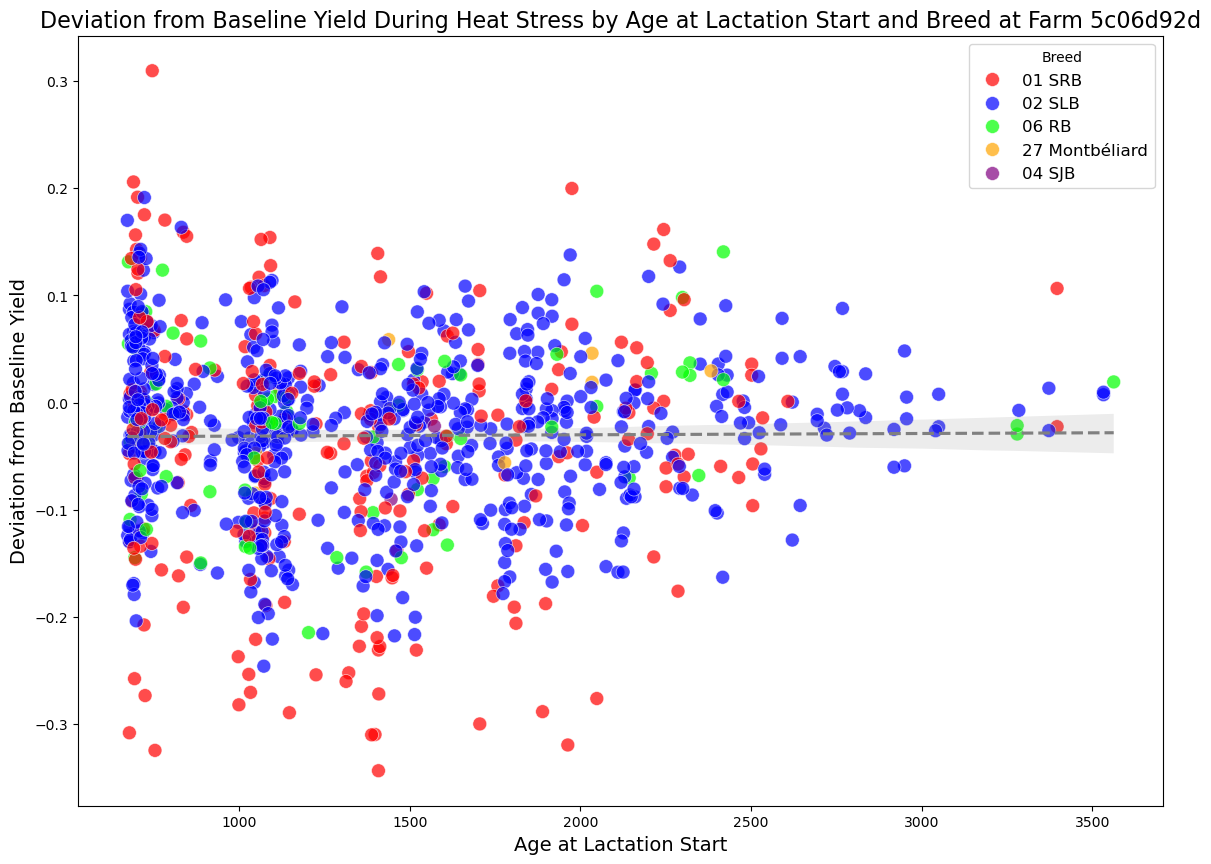

In [11]:
plt.figure(figsize=(14, 10))
sns.scatterplot(x='AgeAtLactationStart', y='Deviation from Baseline HeatStress=1', hue='BreedName', data=results_df, palette=custom_palette, s=100, alpha=0.7, edgecolor='w', linewidth=0.5)
sns.regplot(x='AgeAtLactationStart', y='Deviation from Baseline HeatStress=1', data=results_df, scatter=False, color='gray', line_kws={"linestyle":"--"})
plt.title(f'Deviation from Baseline Yield During Heat Stress by Age at Lactation Start and Breed at Farm {farm}', fontsize=16)
plt.xlabel('Age at Lactation Start', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.legend(title='Breed', fontsize=12)
plt.show()

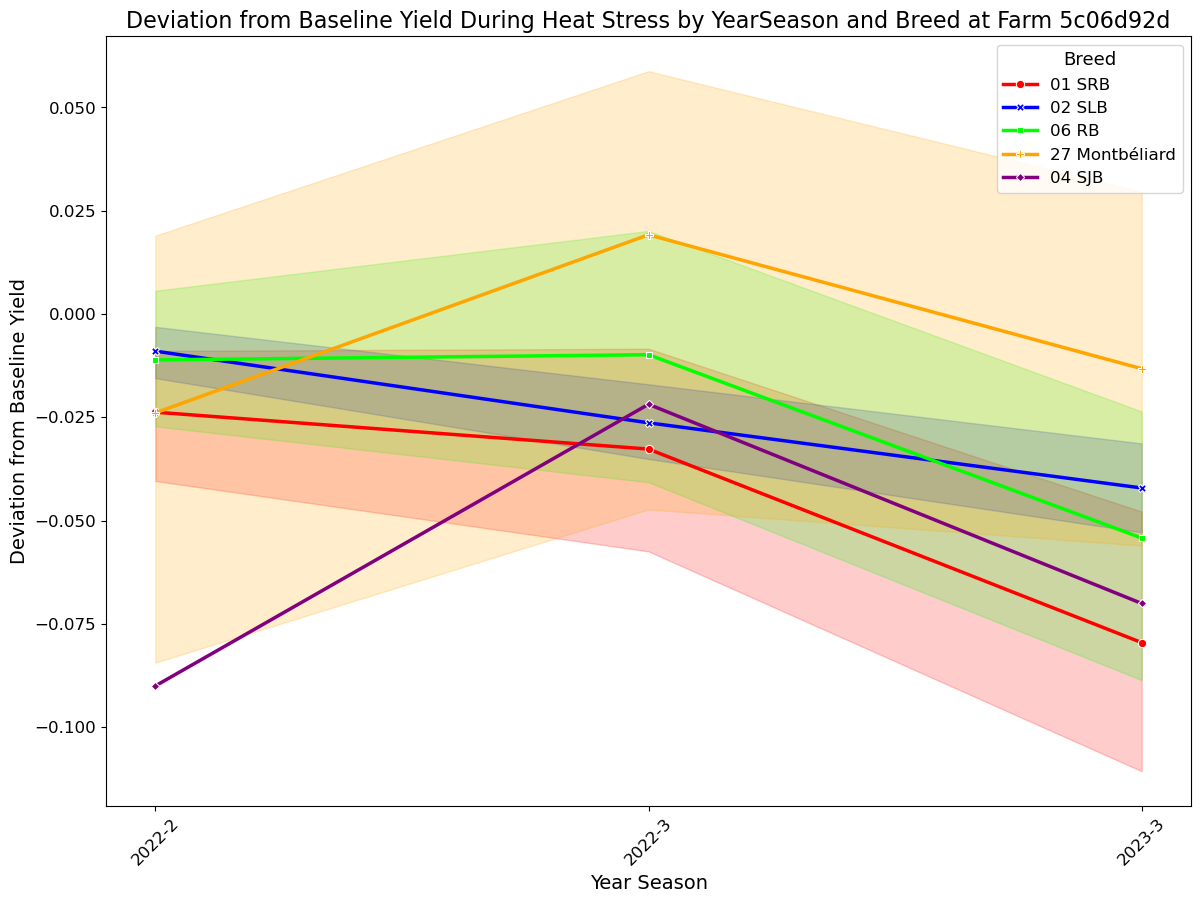

In [12]:
plt.figure(figsize=(14, 10))
sns.lineplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', hue='BreedName', data=results_df, marker='o', palette=custom_palette, linewidth=2.5, style='BreedName', markers=True, dashes=False)
plt.title(f'Deviation from Baseline Yield During Heat Stress by YearSeason and Breed at Farm {farm}', fontsize=16)
plt.xlabel('Year Season', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Breed', fontsize=12, title_fontsize='13')
plt.show()

## Farm 752efd72

In [13]:
# Select the farm
farm = '752efd72'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Ensure the feature 'MeanTemperature' is float type
daily_farm_data['MeanTemperature'] = daily_farm_data['MeanTemperature'].astype(float)

# Scale features
scaler = StandardScaler()
daily_farm_data[['MeanTemperature', 'Age']] = scaler.fit_transform(daily_farm_data[['MeanTemperature', 'Age']])

# Function to fit model and calculate yield change
def fit_model_and_calculate_yield_change(data, feature, additional_features):
    yield_changes = []
    grouped_data = data.groupby(['YearSeason', 'SE_Number'])
    
    for (year_season, cow), group in grouped_data:
        cow_data = group

        # Prepare features
        X = cow_data[[feature] + additional_features]
        y = cow_data['NormalizedDailyYield']

        # Calculate prior mean and variance
        cow_mean = y.mean()
        cow_variance = y.var() if y.var() > 1e-6 else 1e-6
        beta = 1 / cow_variance
        prior_mean_value = X.mean(axis=0)

        # Define priors
        prior_mean = np.append([cow_mean], prior_mean_value.values).reshape(-1, 1)
        prior_cov = np.eye(len(prior_mean)) * 0.01

        # Fit model
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=[feature] + additional_features,
            target='NormalizedDailyYield',
            subject_type='cow',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()

        # Store results
        yield_changes.append({
            'YearSeason': year_season,
            'SE_Number': cow,
            'Yield HeatStress': result['Off-set']['mu']
        })

    return pd.DataFrame(yield_changes)

# Define features
selected_feature = 'MeanTemperature'
additional_features = list(encoded_breeds.columns) + ['Age']

# Separate data for HeatStress=1 and HeatStress=0 conditions
data_heatstress_1 = daily_farm_data[daily_farm_data['HeatStress'] == 1]
data_heatstress_0 = daily_farm_data[daily_farm_data['HeatStress'] == 0]

# Fit models and calculate yield changes
yield_changes_heatstress_1 = fit_model_and_calculate_yield_change(data_heatstress_1, selected_feature, additional_features)
yield_changes_heatstress_0 = fit_model_and_calculate_yield_change(data_heatstress_0, selected_feature, additional_features)

# Merge results with breed data and calculate deviations
results_df = yield_changes_heatstress_1.merge(
    yield_changes_heatstress_0, on=['YearSeason', 'SE_Number'], suffixes=('=1', '=0')
)

# Merge age and breed data back to results_df using the AgeAtLactationStart column
# Ensure unique combinations of SE_Number and YearSeason in the daily_farm_data for merging
unique_age_breed_data = daily_farm_data[['SE_Number', 'YearSeason', 'AgeAtLactationStart', 'BreedName']].drop_duplicates(subset=['SE_Number', 'YearSeason'])

results_df = results_df.merge(
    unique_age_breed_data, on=['SE_Number', 'YearSeason'], how='left'
)

# Calculate the correct deviation from baseline
# baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress_1['FarmHeatStressMilkProduction'].mean()
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change  # Corrected calculation

# Reorder columns to make SE_Number the first column
results_df = results_df[['SE_Number', 'YearSeason', 'AgeAtLactationStart', 'BreedName', 'Yield HeatStress=1', 'Yield HeatStress=0', 'Deviation from Baseline HeatStress=1']]
results_df

,SE_Number,YearSeason,AgeAtLactationStart,BreedName,Yield HeatStress=1,Yield HeatStress=0,Deviation from Baseline HeatStress=1
0,SE-752efd72-0001,2022-2,2022,Unknown Breed,0.910971,0.891221,-0.089093
1,SE-752efd72-0002,2022-2,1966,02 SLB,1.004986,0.670922,0.004921
2,SE-752efd72-0008,2022-2,1896,02 SLB,0.947314,0.828485,-0.052750
3,SE-752efd72-0010,2022-2,1953,02 SLB,0.841317,1.224562,-0.158747
4,SE-752efd72-0011,2022-2,1966,02 SLB,0.867971,0.938737,-0.132093
...,...,...,...,...,...,...,...
939,SE-752efd72-2709,2023-3,2552,02 SLB,1.029467,0.970951,0.029403
940,SE-752efd72-2777,2023-3,2232,02 SLB,0.979058,0.793767,-0.021006
941,SE-752efd72-2780,2023-3,2536,02 SLB,1.059753,0.914871,0.059689
942,SE-752efd72-2784,2023-3,2210,02 SLB,1.039314,1.161707,0.039250


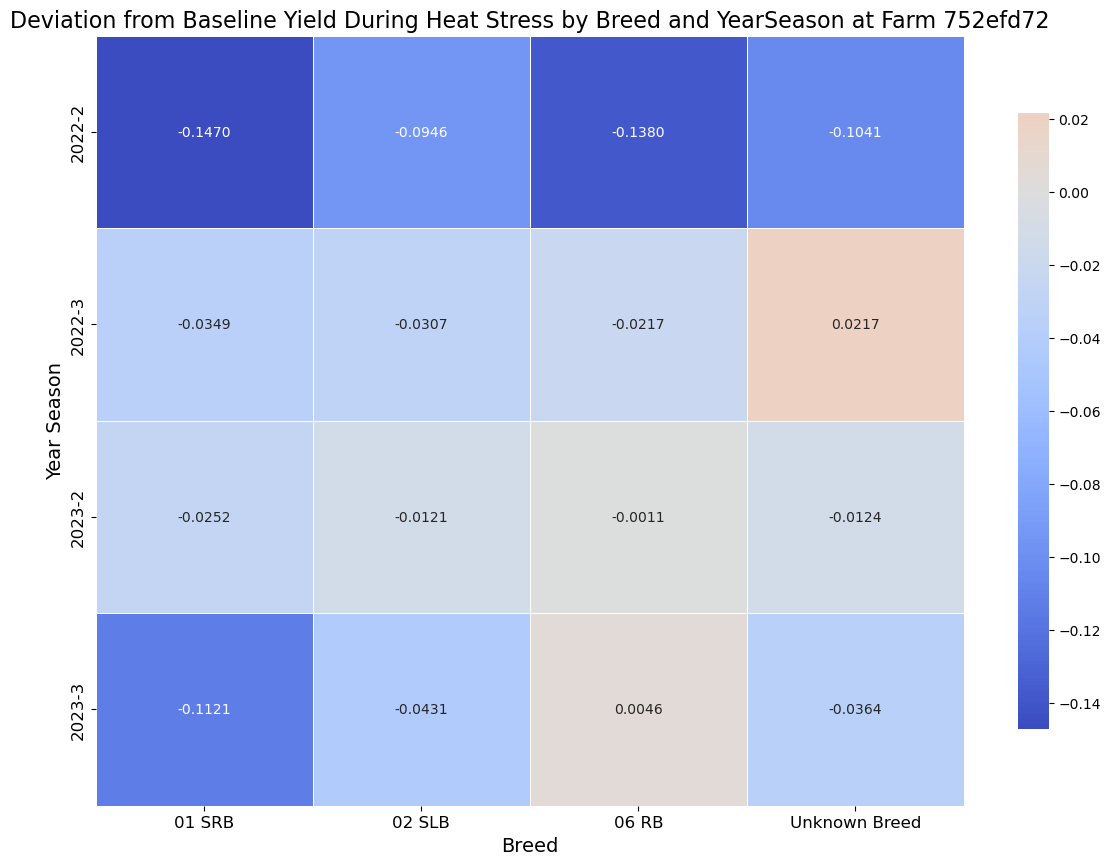

In [14]:
# Pivot data for heatmap
heatmap_data = results_df.pivot_table(index='YearSeason', columns='BreedName', values='Deviation from Baseline HeatStress=1')

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0, fmt=".4f", linewidths=.5, cbar_kws={"shrink": .8})
plt.title(f'Deviation from Baseline Yield During Heat Stress by Breed and YearSeason at Farm {farm}', fontsize=16)
plt.xlabel('Breed', fontsize=14)
plt.ylabel('Year Season', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

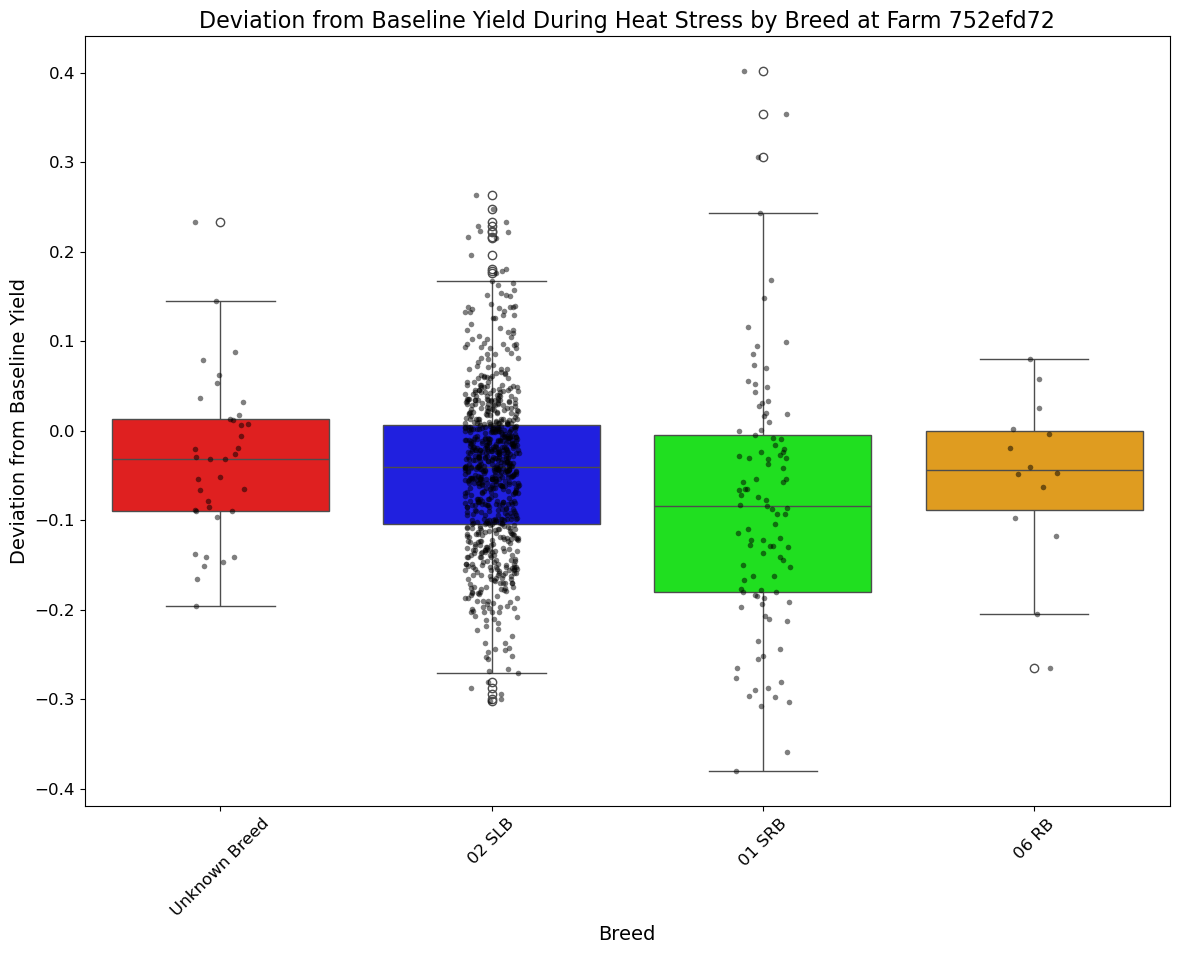

In [15]:
# Define a custom color palette with bright colors
custom_palette = ['#FF0000', '#0000FF', '#00FF00', '#FFA500']  # Bright red, Bright blue, Bright green, Bright orange

plt.figure(figsize=(14, 10))
sns.boxplot(x='BreedName', y='Deviation from Baseline HeatStress=1', data=results_df, hue='BreedName', palette=custom_palette, dodge=False)
sns.stripplot(x='BreedName', y='Deviation from Baseline HeatStress=1', data=results_df, color='black', size=4, jitter=True, alpha=0.5, dodge=False)
plt.title(f'Deviation from Baseline Yield During Heat Stress by Breed at Farm {farm}', fontsize=16)
plt.xlabel('Breed', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend([],[], frameon=False)  # Remove the legend
plt.show()

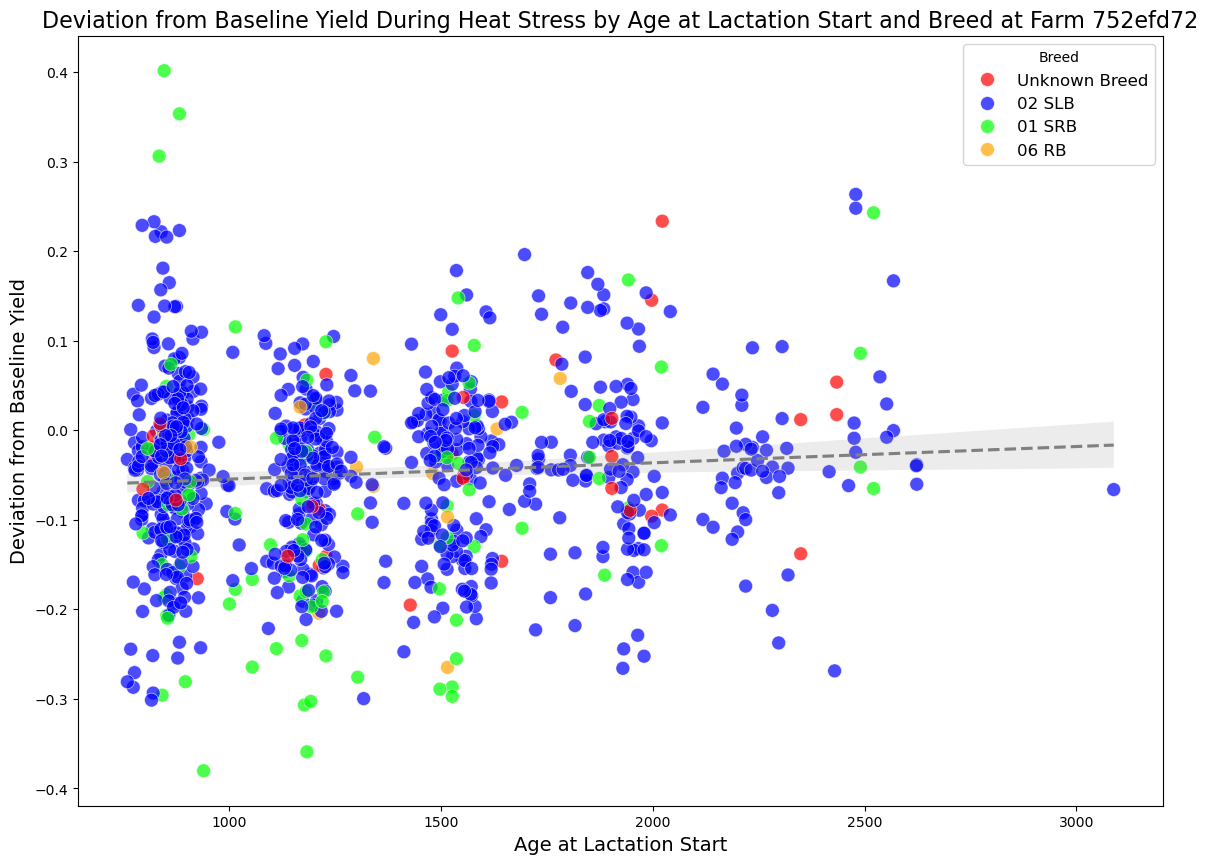

In [16]:
plt.figure(figsize=(14, 10))
sns.scatterplot(x='AgeAtLactationStart', y='Deviation from Baseline HeatStress=1', hue='BreedName', data=results_df, palette=custom_palette, s=100, alpha=0.7, edgecolor='w', linewidth=0.5)
sns.regplot(x='AgeAtLactationStart', y='Deviation from Baseline HeatStress=1', data=results_df, scatter=False, color='gray', line_kws={"linestyle":"--"})
plt.title(f'Deviation from Baseline Yield During Heat Stress by Age at Lactation Start and Breed at Farm {farm}', fontsize=16)
plt.xlabel('Age at Lactation Start', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.legend(title='Breed', fontsize=12)
plt.show()

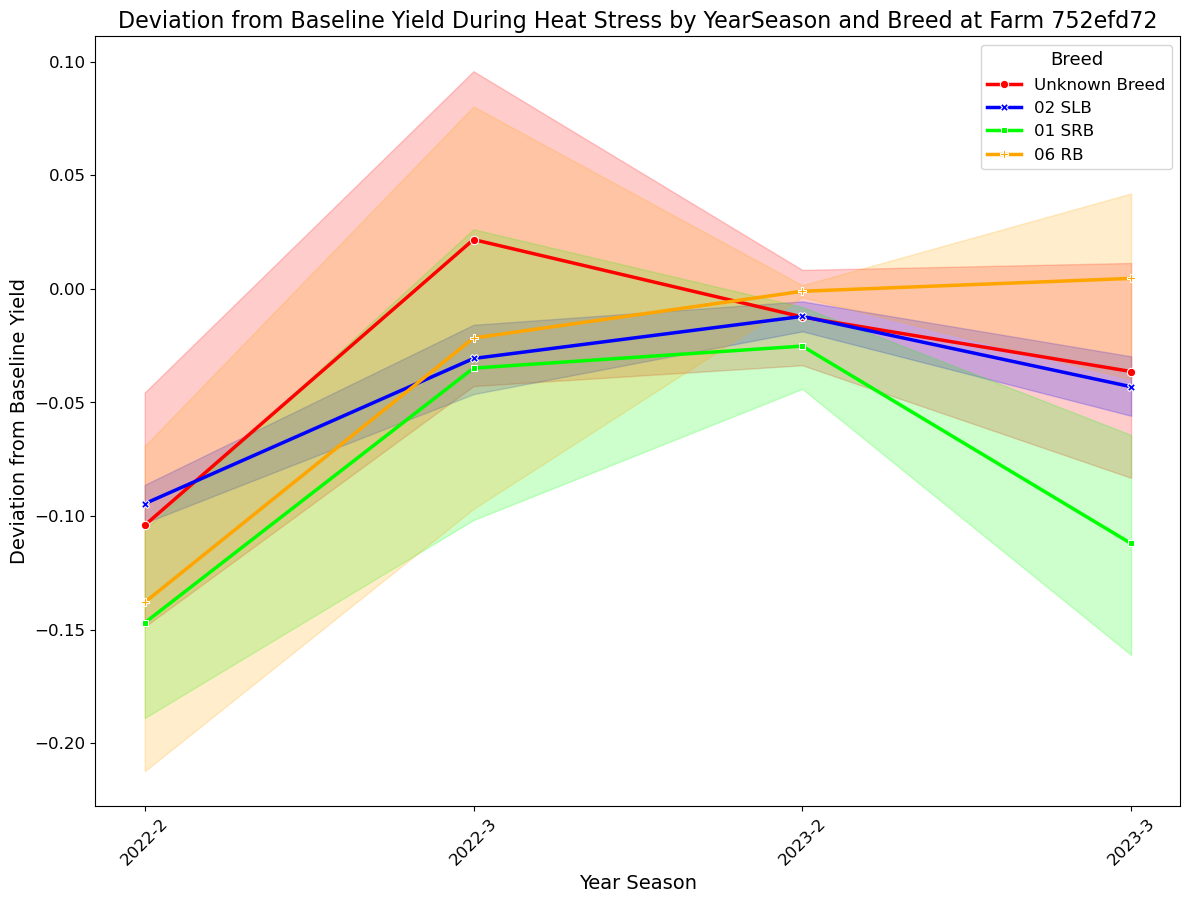

In [17]:
plt.figure(figsize=(14, 10))
sns.lineplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', hue='BreedName', data=results_df, marker='o', palette=custom_palette, linewidth=2.5, style='BreedName', markers=True, dashes=False)
plt.title(f'Deviation from Baseline Yield During Heat Stress by YearSeason and Breed at Farm {farm}', fontsize=16)
plt.xlabel('Year Season', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Breed', fontsize=12, title_fontsize='13')
plt.show()

## Farm f454e660

In [18]:
# Select the farm
farm = 'f454e660'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Ensure the feature 'MeanTemperature' is float type
daily_farm_data['MeanTemperature'] = daily_farm_data['MeanTemperature'].astype(float)

# Scale features
scaler = StandardScaler()
daily_farm_data[['MeanTemperature', 'Age']] = scaler.fit_transform(daily_farm_data[['MeanTemperature', 'Age']])

# Function to fit model and calculate yield change
def fit_model_and_calculate_yield_change(data, feature, additional_features):
    yield_changes = []
    grouped_data = data.groupby(['YearSeason', 'SE_Number'])
    
    for (year_season, cow), group in grouped_data:
        cow_data = group

        # Prepare features
        X = cow_data[[feature] + additional_features]
        y = cow_data['NormalizedDailyYield']

        # Calculate prior mean and variance
        cow_mean = y.mean()
        cow_variance = y.var() if y.var() > 1e-6 else 1e-6
        beta = 1 / cow_variance
        prior_mean_value = X.mean(axis=0)

        # Define priors
        prior_mean = np.append([cow_mean], prior_mean_value.values).reshape(-1, 1)
        prior_cov = np.eye(len(prior_mean)) * 0.01

        # Fit model
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=[feature] + additional_features,
            target='NormalizedDailyYield',
            subject_type='cow',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()

        # Store results
        yield_changes.append({
            'YearSeason': year_season,
            'SE_Number': cow,
            'Yield HeatStress': result['Off-set']['mu']
        })

    return pd.DataFrame(yield_changes)

# Define features
selected_feature = 'MeanTemperature'
additional_features = list(encoded_breeds.columns) + ['Age']

# Separate data for HeatStress=1 and HeatStress=0 conditions
data_heatstress_1 = daily_farm_data[daily_farm_data['HeatStress'] == 1]
data_heatstress_0 = daily_farm_data[daily_farm_data['HeatStress'] == 0]

# Fit models and calculate yield changes
yield_changes_heatstress_1 = fit_model_and_calculate_yield_change(data_heatstress_1, selected_feature, additional_features)
yield_changes_heatstress_0 = fit_model_and_calculate_yield_change(data_heatstress_0, selected_feature, additional_features)

# Merge results with breed data and calculate deviations
results_df = yield_changes_heatstress_1.merge(
    yield_changes_heatstress_0, on=['YearSeason', 'SE_Number'], suffixes=('=1', '=0')
)

# Merge age and breed data back to results_df using the AgeAtLactationStart column
# Ensure unique combinations of SE_Number and YearSeason in the daily_farm_data for merging
unique_age_breed_data = daily_farm_data[['SE_Number', 'YearSeason', 'AgeAtLactationStart', 'BreedName']].drop_duplicates(subset=['SE_Number', 'YearSeason'])

results_df = results_df.merge(
    unique_age_breed_data, on=['SE_Number', 'YearSeason'], how='left'
)

# Calculate the correct deviation from baseline
# baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress_1['FarmHeatStressMilkProduction'].mean()
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change  # Corrected calculation

# Reorder columns to make SE_Number the first column
results_df = results_df[['SE_Number', 'YearSeason', 'AgeAtLactationStart', 'BreedName', 'Yield HeatStress=1', 'Yield HeatStress=0', 'Deviation from Baseline HeatStress=1']]
results_df

,SE_Number,YearSeason,AgeAtLactationStart,BreedName,Yield HeatStress=1,Yield HeatStress=0,Deviation from Baseline HeatStress=1
0,SE-a2bab923-0680,2022-3,4202,04 SJB,0.984435,0.931988,-0.015439
1,SE-f454e660-0139,2022-3,2972,04 SJB,0.976162,1.164296,-0.023712
2,SE-f454e660-0157,2022-3,2736,02 SLB,0.953043,0.833295,-0.046831
3,SE-f454e660-0235,2022-3,2398,02 SLB,1.029145,0.875406,0.029271
4,SE-f454e660-0250,2022-3,2351,02 SLB,0.958273,0.887917,-0.041601
...,...,...,...,...,...,...,...
499,SE-f454e660-587,2023-3,1474,99 Korsning/obestämbar ras,0.989359,1.015510,-0.010515
500,SE-f454e660-600,2023-3,1110,01 SRB,0.965455,1.046343,-0.034419
501,SE-f454e660-636,2023-3,1330,04 SJB,0.971154,0.962858,-0.028720
502,SE-f454e660-712,2023-3,826,99 Korsning/obestämbar ras,0.958131,1.201785,-0.041743


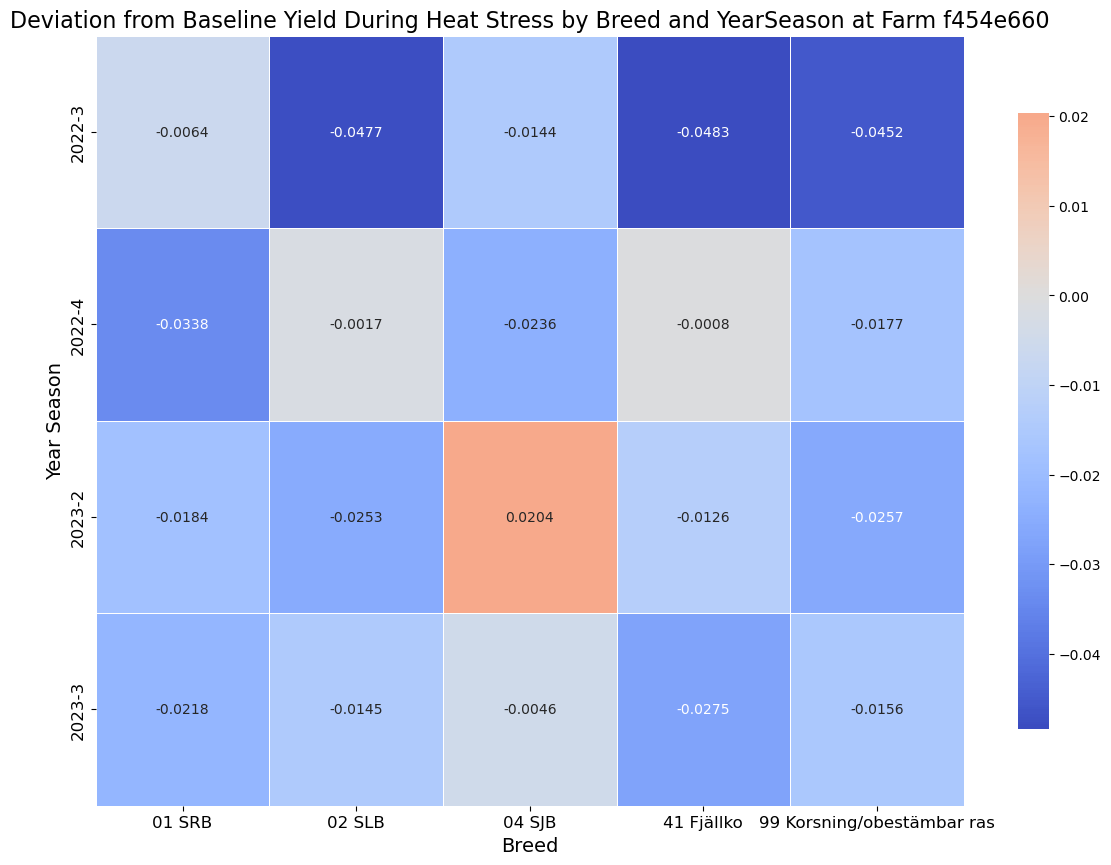

In [19]:
# Pivot data for heatmap
heatmap_data = results_df.pivot_table(index='YearSeason', columns='BreedName', values='Deviation from Baseline HeatStress=1')

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0, fmt=".4f", linewidths=.5, cbar_kws={"shrink": .8})
plt.title(f'Deviation from Baseline Yield During Heat Stress by Breed and YearSeason at Farm {farm}', fontsize=16)
plt.xlabel('Breed', fontsize=14)
plt.ylabel('Year Season', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

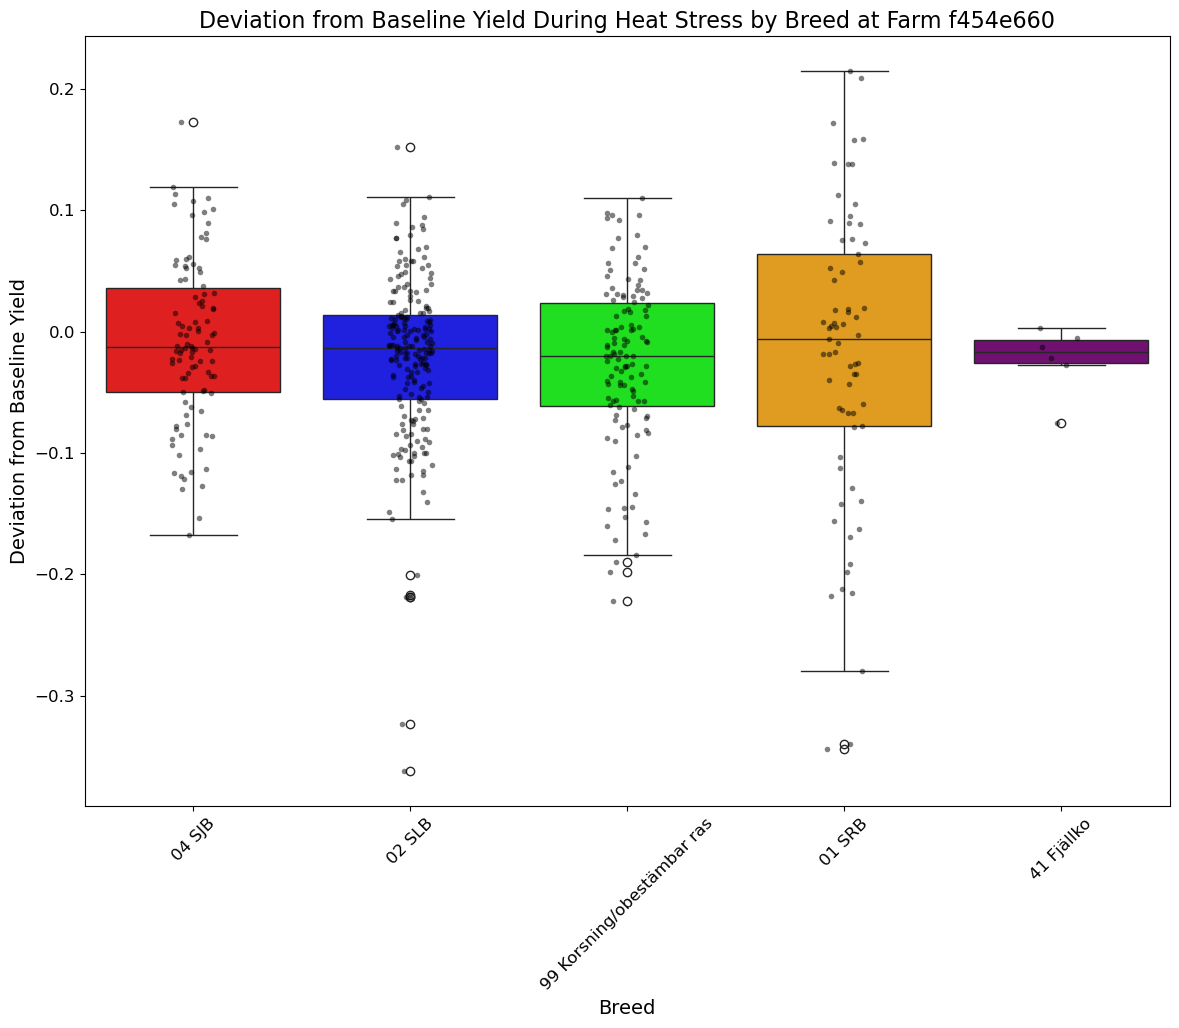

In [20]:
# Define a custom color palette with bright colors
custom_palette = ['#FF0000', '#0000FF', '#00FF00', '#FFA500', '#800080']  # Bright red, Bright blue, Bright green, Bright orange, Bright purple

plt.figure(figsize=(14, 10))
sns.boxplot(x='BreedName', y='Deviation from Baseline HeatStress=1', data=results_df, hue='BreedName', palette=custom_palette, dodge=False)
sns.stripplot(x='BreedName', y='Deviation from Baseline HeatStress=1', data=results_df, color='black', size=4, jitter=True, alpha=0.5, dodge=False)
plt.title(f'Deviation from Baseline Yield During Heat Stress by Breed at Farm {farm}', fontsize=16)
plt.xlabel('Breed', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend([],[], frameon=False)  # Remove the legend
plt.show()

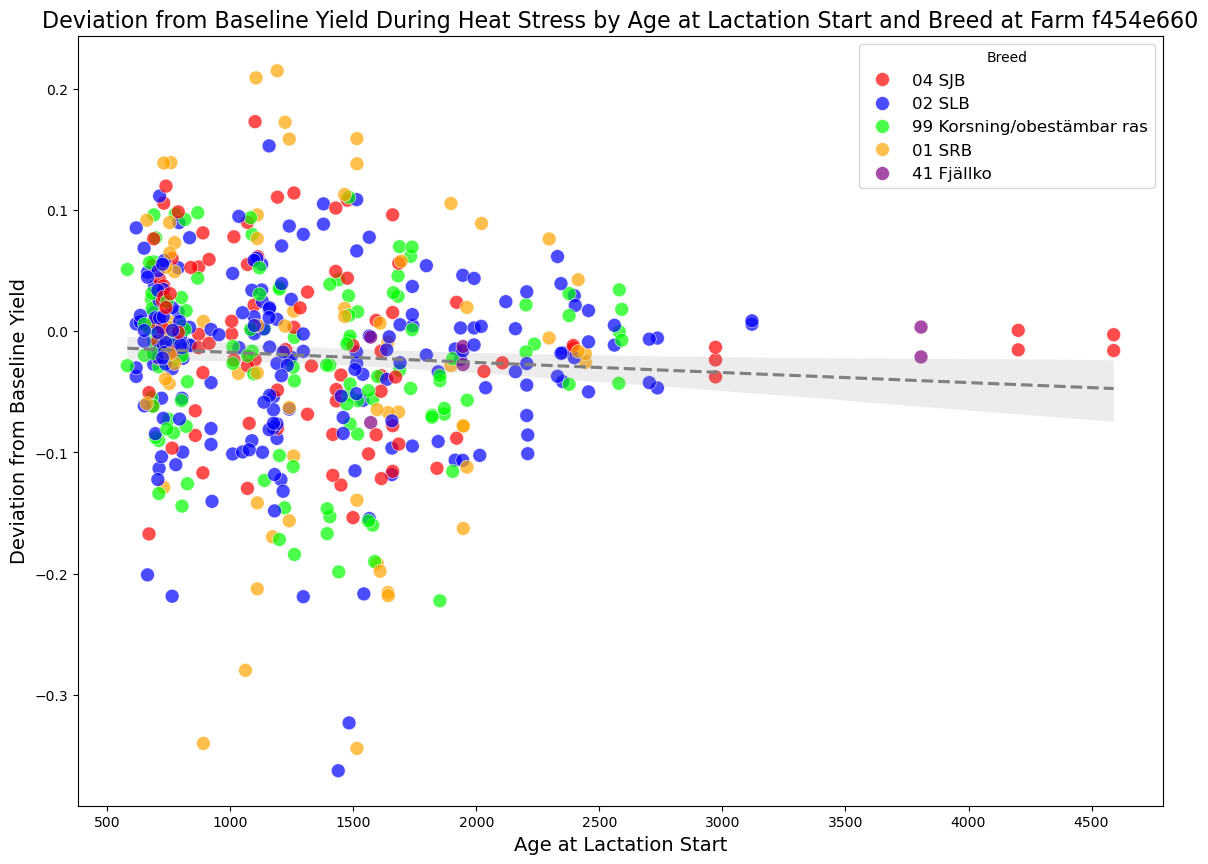

In [21]:
plt.figure(figsize=(14, 10))
sns.scatterplot(x='AgeAtLactationStart', y='Deviation from Baseline HeatStress=1', hue='BreedName', data=results_df, palette=custom_palette, s=100, alpha=0.7, edgecolor='w', linewidth=0.5)
sns.regplot(x='AgeAtLactationStart', y='Deviation from Baseline HeatStress=1', data=results_df, scatter=False, color='gray', line_kws={"linestyle":"--"})
plt.title(f'Deviation from Baseline Yield During Heat Stress by Age at Lactation Start and Breed at Farm {farm}', fontsize=16)
plt.xlabel('Age at Lactation Start', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.legend(title='Breed', fontsize=12)
plt.show()

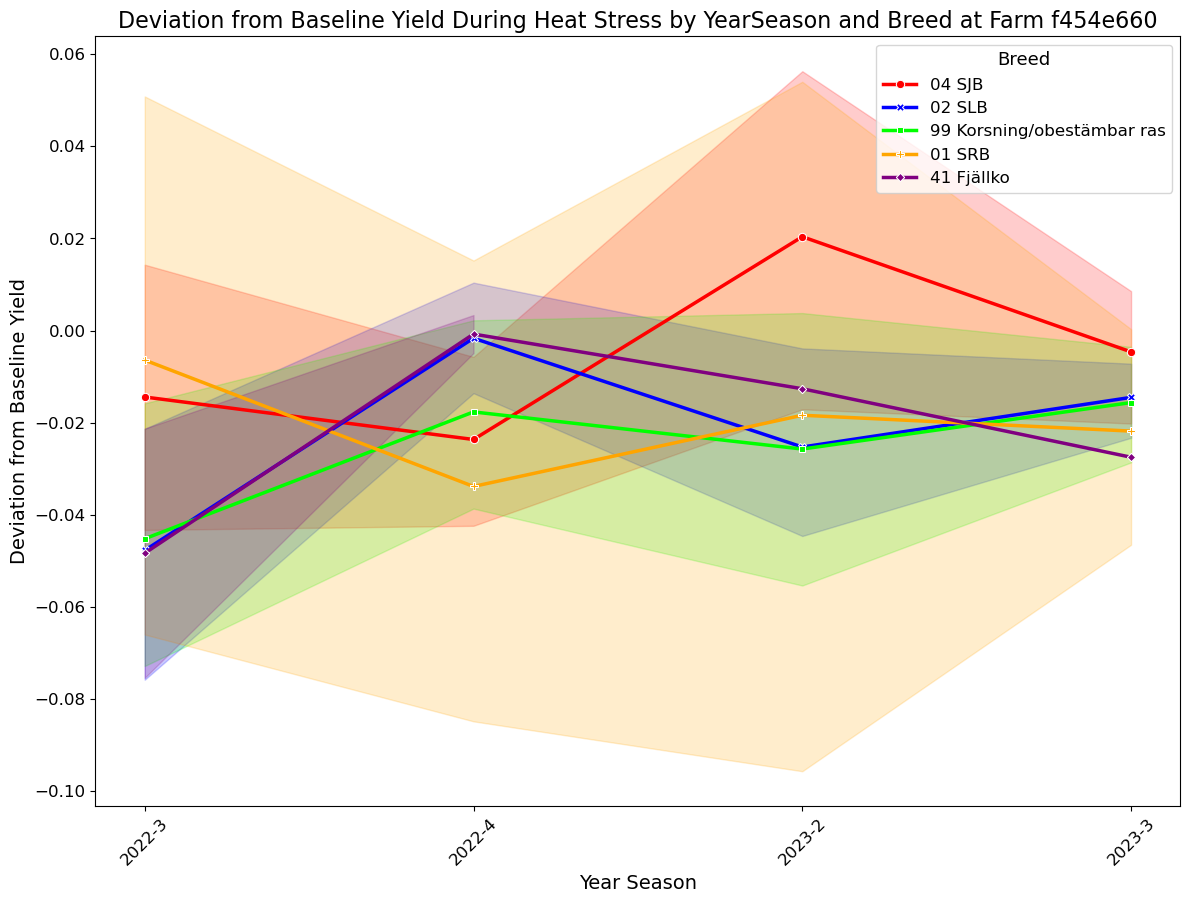

In [22]:
plt.figure(figsize=(14, 10))
sns.lineplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', hue='BreedName', data=results_df, marker='o', palette=custom_palette, linewidth=2.5, style='BreedName', markers=True, dashes=False)
plt.title(f'Deviation from Baseline Yield During Heat Stress by YearSeason and Breed at Farm {farm}', fontsize=16)
plt.xlabel('Year Season', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Breed', fontsize=12, title_fontsize='13')
plt.show()